In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime
from dual import dual
from uniform import uniform
import ray
import logging
%matplotlib inline

In [2]:
@ray.remote
def get_uniform_result(c, con, cr, return_prop, step, density):
    uniform_ins = uniform(c=c, con=con, return_prop=return_prop, cr=cr, step=step, density=density)
    return uniform_ins.p, uniform_ins.profit


@ray.remote
def get_dual_result(c, con, cr, return_prop, step, density):
    dual_ins = dual(c=c, con=con, return_prop=return_prop, cr=cr, step=step, density=density)
    return dual_ins.pon, dual_ins.poff, dual_ins.profit


def main(ms, filenames, plot=False, save=False):
    for m, filename in zip(ms, filenames):
        p_list = []
        piu_list = []

        pon_list = []
        poff_list = []
        pid_list = []

        cr = 0.35
        con = 0.05
        step = 0.001
        density = 0.005
        sel_c = np.arange(0.1, 0.15, 0.0025)

        results_uniform_id = []
        results_dual_id = []

        for c in sel_c:
            results_uniform_id.append(
                get_uniform_result.remote(c=c, con=con, cr=cr, return_prop=m, step=step, density=density))
            results_dual_id.append(
                get_dual_result.remote(c=c, con=con, cr=cr, return_prop=m, step=step, density=density))

        results_uniform = ray.get(results_uniform_id)
        results_dual = ray.get(results_dual_id)

        for result_uniform, result_dual in zip(results_uniform, results_dual):
            p_list.append(result_uniform[0])
            piu_list.append(result_uniform[1])

            pon_list.append(result_dual[0])
            poff_list.append(result_dual[1])
            pid_list.append(result_dual[2])

        if plot:
            fig = plt.figure(figsize=(5, 8))
            ax1 = fig.add_subplot(2, 1, 1)
            ax1.plot(sel_c, piu_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax1.plot(sel_c, pid_list, c='blue', ls='--', ms=6, marker='o', label="Dual")

            ax2 = fig.add_subplot(2, 1, 2)
            ax2.plot(sel_c, p_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
            ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
                     label="Offline of Dual")

            ax1.legend(prop=dict(size=9), frameon=False)
            ax1.set_ylabel("Profits", fontsize=16)
            ax1.set_xlabel("c", fontsize=16)

            ax2.legend(prop=dict(size=9), frameon=False)
            ax2.set_ylabel("Prices", fontsize=16)
            ax2.set_xlabel("c", fontsize=16)

            plt.tight_layout()
            plt.show()
        if save:
            cols = ["c", "p_u", "pi_u", "pon", "poff", "pi_d"]
            data = np.array([sel_c, p_list, piu_list, pon_list, poff_list, pid_list]).T

            data_frame = pd.DataFrame(data=data, columns=cols)
            data_frame.to_excel(filename, index=False)

        logger.info("a work is finished...")

In [10]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability
ms = ["constant",2] 
filenames = []
for ind, m in enumerate(ms):
    filenames.append("file"+str(ind)+".xlsx")

main(ms, filenames, save=True)
end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 18 seconds


In [11]:
data = []

for file in filenames:
    data.append(pd.read_excel(file,sheet_name=0))

In [12]:
len(data)

2

In [13]:
data[0].head(5)

,c,p_u,pi_u,pon,poff,pi_d
0,0.1000,0.400,0.040000,0.350,0.400,0.040000
1,0.1025,0.395,0.039500,0.345,0.395,0.039500
2,0.1050,0.395,0.039006,0.345,0.395,0.039006
3,0.1075,0.390,0.038513,0.340,0.390,0.038513
4,0.1100,0.390,0.038025,0.340,0.390,0.038025


In [14]:
max(data[0].c)

0.1475

In [15]:
def plot(data,ms, fz=(20,8)):
    fig,axes = plt.subplots(2, len(data), sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    for j,current_data  in enumerate(data):
        sel_c = current_data["c"]
        min_c_ind = min(sel_c)
        max_c_ind = max(sel_c)
        step = sel_c[1]-sel_c[0]

        sel_prices_u = current_data["p_u"]
        sel_prices_d_on =  current_data["pon"]
        sel_prices_d_off =  current_data["poff"]


        axes[0,j].plot(sel_c, sel_prices_u, c='red', ls='--', ms=6, marker='^', markerfacecolor='none',label="Uniform")
        axes[0,j].plot(sel_c, sel_prices_d_on, c='blue', ls='--', ms=6, marker='o',  markerfacecolor='none',label="Online of Dual")
        axes[0,j].plot(sel_c, sel_prices_d_off, c='green', ls='--', ms=6, marker='D',
                 markerfacecolor='none',label="Offline of Dual")

        axes[0,j].legend(prop=dict(size=12), frameon=False)

        #axes[0,j].set_xlabel("c", fontsize =16)

        axes[0,j].set_title(r"$m$={} ".format(ms[j]), fontsize=22)
#         axes[0,j].set_xlim((0.1,0.17))
#         axes[0,j].set_ylim((0.28,0.46))
        
        for label in (axes[0,j].get_xticklabels() + axes[0,j].get_yticklabels()):
            label.set_fontsize(16)

        sel_profits_u = current_data["pi_u"]
        sel_profits_d = current_data["pi_d"]

        axes[1,j].plot(sel_c, sel_profits_u,c='red', ls='--', ms=6, marker='^', markerfacecolor='none', label="Uniform")
        axes[1,j].plot(sel_c, sel_profits_d,c='blue', ls='--', ms=6, marker='o',markerfacecolor='none',label="Dual")

        axes[1,j].legend(prop=dict(size=12), frameon=False)
#         axes[1,j].set_ylim((0.03,0.042))
#         axes[1,j].set_xlim((0.1,0.17))
        
        for label in (axes[1,j].get_xticklabels() + axes[1,j].get_yticklabels()):
            label.set_fontsize(16)
    axes[0,0].set_ylabel("Prices", fontsize =22)
    axes[1,0].set_ylabel("Profits", fontsize =22)
    fig.text(0.5, 0, 'c', ha='center',fontsize =22)
    fig.tight_layout()
    return fig

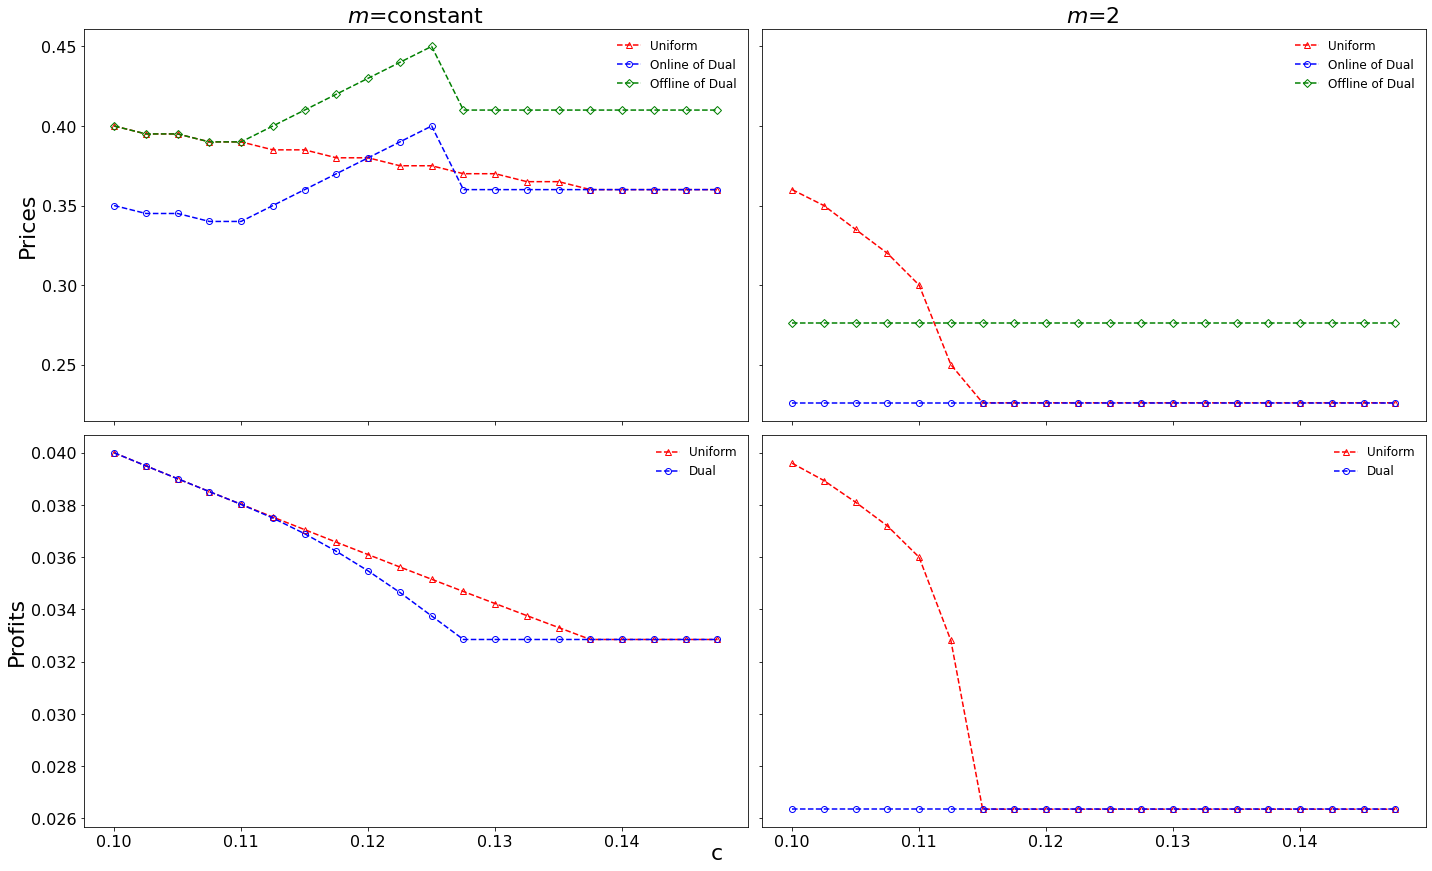

In [16]:
myfig = plot(data,ms=ms, fz=(20,12))